In [19]:
from agd.loader.load_chembl import parse_activities
from agd.loader.clean_chembl import clean_data
import pandas as pd
import random
import numpy as np

In [20]:
# set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [4]:
target_id = "CHEMBL262"

In [5]:
target_raw = parse_activities(target_id)
target_raw.shape

INFO:agd.loader.load_chembl:Loading cached data from D:\python_projects\alzheimer-generative-design\data\CHEMBL262_raw.csv


(4587, 46)

In [6]:
target_clean = clean_data(target_id)
target_clean.shape

(3634, 2)

In [7]:
import numpy as np

y10 = target_clean['standard_value'] * 1e-9 # to moles
y10 = -np.log10(y10)
y10.dropna(inplace=True)
y10.head()

D:\python_projects\alzheimer-generative-design\venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


molecule_chembl_id
CHEMBL388978     7.522879
CHEMBL102714     7.703335
CHEMBL259850     6.309804
CHEMBL50894      8.187087
CHEMBL3545157    6.856985
Name: standard_value, dtype: float64

In [8]:
ids = y10.index

In [9]:
from agd.predictor.feature_extraction import get_features_dataset

rdkit_desc = get_features_dataset(target_id=target_id, descriptors=["rdkit"])
rdkit_desc.shape

(3634, 219)

In [10]:
from agd.predictor.processing import remove_collinear_features

x_rdkit_desc = rdkit_desc.drop(columns=["smiles", "standard_value"])
x_rdkit_desc = x_rdkit_desc.loc[ids, :]
x_rdkit_desc.dropna(axis=1, how="any", inplace=True)
x_rdkit_desc = x_rdkit_desc.select_dtypes(include=['number'])
x_rdkit_desc = x_rdkit_desc.loc[:, x_rdkit_desc.std() != 0]
x_rdkit_desc.shape

(3630, 196)

In [11]:
x_rdkit_filtered = remove_collinear_features(x_rdkit_desc, threshold=0.7)
x_rdkit_filtered.shape

(3630, 117)

In [12]:
from agd.predictor.feature_extraction import get_features_dataset

radius = 3
fp_size = 1024
morgan_fp = get_features_dataset(
    target_id=target_id,
    fingerprints={
        "morgan": {
            "params": {
                "radius": radius,
                "fpSize": fp_size
            }
        }
    }
)
morgan_fp.shape

(3634, 1026)

In [13]:
x_morgan_fp = morgan_fp.drop(columns=["smiles", "standard_value"])
x_morgan_fp = x_morgan_fp.loc[ids, :]
x_morgan_fp.shape

(3630, 1024)

In [17]:
x_rdkit_morgan = pd.concat([x_rdkit_filtered, x_morgan_fp], axis=1)
x_rdkit_morgan.shape

(3630, 1141)

In [21]:
from sklearn.model_selection import KFold

n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
scoring = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']
results_path = 'results.csv'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min finished


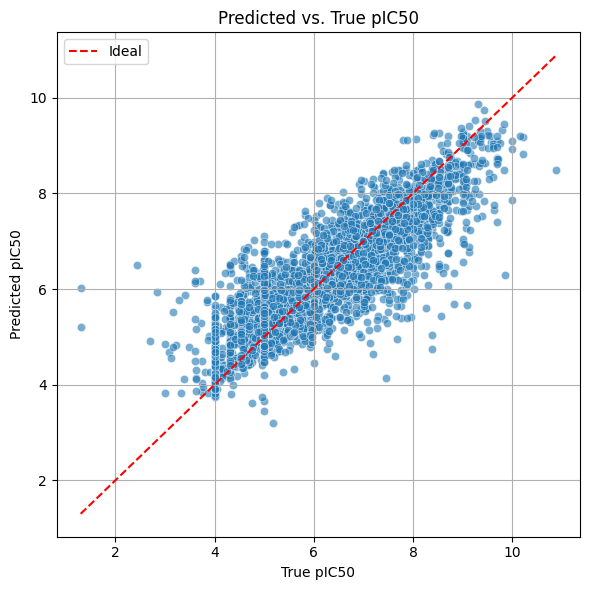

Cross-validation mean scores:
  r2, mean: 0.7236, std: 0.0202
  neg_mean_absolute_error, mean: -0.5233, std: 0.0207
  neg_root_mean_squared_error, mean: -0.7234, std: 0.0360
Created new results file at results.csv


In [22]:
from agd.predictor.pipeline import run_pipeline
from catboost import CatBoostRegressor

estimator, pipeline = run_pipeline(
    X=x_rdkit_morgan,
    y=y10.squeeze(),
    cv=cv,
    model=CatBoostRegressor(
        iterations=1500,
        learning_rate=0.03,
        depth=8,
        l2_leaf_reg=3,
        bagging_temperature=1.0,
        random_strength=1.0,
        grow_policy="Lossguide",
        min_data_in_leaf=5,
        border_count=128,
        early_stopping_rounds=50,
    ),
    # scaler=RobustScaler(),
    # selector=SelectKBest(f_regression, k=1000),
    # dim_reducer=PCA(n_components=100),
    scoring=scoring,
    results_path=results_path,
)